- 데이터 필터링은 charge session 단위가 아니라 'cid' 단위로 할것.
    - 동일 cid의 일부 charge sessio을 제외할 경우 시간순에 따라 windowing을 하여 피쳐를 생성하는 과정에서 왜곡이 발생함

In [1]:
import pandas as pd

pd.options.display.float_format = '{: .2f}'.format

In [14]:
# 가장 최근의 2021년 7월~ 12월 (6개월) 데이터 로드

df = pd.read_csv('../data/한국전력공사_전기차충전소충전량(202107_202112).csv', 
                 parse_dates=['충전종료일자', '충전시작시각', '충전종료시각'], 
                 encoding='cp949') 

In [15]:
drop_cols = ['본부', '사업소', '충전소명', '충전기', '주소', '충전종료일자']
rename_dict = {'충전기ID':'cid', '충전기구분':'charger_type', '충전용량':'charging_power', 
               '충전량':'charge_amount', '충전시간':'hour', '충전분':'minute',
               '충전시작시각':'start_time', '충전종료시각':'finish_time'}

df = df.drop(drop_cols, axis=1).rename(columns=rename_dict)
df = df.loc[df['charger_type'] == '급속']
df['duration'] = df.hour.multiply(60).add(df.minute)
df = df.drop(['charger_type', 'hour', 'minute'], axis=1)

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 583023 entries, 1 to 1048572
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   cid             583023 non-null  int64         
 1   charging_power  556320 non-null  float64       
 2   charge_amount   583023 non-null  float64       
 3   start_time      583023 non-null  datetime64[ns]
 4   finish_time     583023 non-null  datetime64[ns]
 5   duration        583023 non-null  int64         
dtypes: datetime64[ns](2), float64(2), int64(2)
memory usage: 31.1 MB


In [17]:
# 8080개 device
df.cid.nunique()

8080

In [18]:
# 7~12월 간의 데이터이지만 실질적으로 10월 17일까지의 로그만 존재함
df.describe(datetime_is_numeric=True)

# 7~9의 3개월 데이터만 분리
df = df[df.start_time.between('2021-07-01', '2021-10-01')]
df.cid.nunique()

7723

In [19]:
# 실질적으로 활발히 운영되는 충전기로 한정하기 위하여, 분석기간(3개월) 내 첫주와 마지막주에 모두 충전시작이 있는 충전기로 제한

first_charge = df.groupby('cid')['start_time'].min()
valid_id_first = first_charge[first_charge < '2021-07-07'].index

last_charge = df.groupby('cid')['start_time'].max()
valid_id_last = last_charge[last_charge > '2021-09-23'].index

In [20]:
# 총 3,213개의 충전기
valid_cid = set(valid_id_first).intersection(valid_id_last)
len(valid_cid)

3213

In [21]:
# 총 충전의 90% 이상이며 3개월간 441,530건
df.cid.isin(valid_cid).mean(), df.cid.isin(valid_cid).sum()

(0.9060910215866905, 441530)

In [22]:
# valid_cid의 로그만 선택하여 charge 테이블 생성
charge = df[df.cid.isin(valid_cid)].copy()

In [23]:
charge.head()

,cid,charging_power,charge_amount,start_time,finish_time,duration
10,8833,50.00,13.00,2021-07-01 11:19:00,2021-07-01 11:41:11,22
11,471,50.00,27.05,2021-07-01 07:26:01,2021-07-01 08:05:16,39
12,471,50.00,10.64,2021-07-01 13:56:30,2021-07-01 14:17:05,20
24,792,50.00,36.35,2021-07-01 01:50:09,2021-07-01 03:04:14,74
27,879,50.00,7.69,2021-07-01 07:14:24,2021-07-01 07:54:04,39


In [24]:
# charging_power에서 null 발생 ->  피쳐로 활용할 것 이므로 null row 제거
charge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 441530 entries, 10 to 899545
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   cid             441530 non-null  int64         
 1   charging_power  436187 non-null  float64       
 2   charge_amount   441530 non-null  float64       
 3   start_time      441530 non-null  datetime64[ns]
 4   finish_time     441530 non-null  datetime64[ns]
 5   duration        441530 non-null  int64         
dtypes: datetime64[ns](2), float64(2), int64(2)
memory usage: 23.6 MB


In [41]:
power_null_ids = charge[charge.charging_power.isna()].cid.unique()
charge = charge[~charge.cid.isin(power_null_ids)]

In [42]:
charge.charging_power.unique()

array([ 50., 200., 100.])

### duration 이상치 필터링

In [43]:
charge.duration.describe()

count    436187.00
mean         51.09
std          83.39
min           0.00
25%          25.00
50%          42.00
75%          66.00
max       24369.00
Name: duration, dtype: float64

In [45]:
import numpy as np

def outlier_bound(array):
    stdev = np.std(array)
    med = np.median(array)
    return med - 3*stdev, med + 3*stdev

outlier_bound(charge.duration)

(-208.18165142488976, 292.18165142488976)

In [55]:
# 292분 초과하는 경우 1,915건으로 전체 중 0.4% 가량
charge.duration.gt(outlier_bound(charge.duration)[1]).sum(), charge.duration.gt(outlier_bound(charge.duration)[1]).mean()

(1915, 0.004390318831143524)

In [56]:
outlier_cid = charge[charge.duration.gt(outlier_bound(charge.duration)[1])].cid.unique()

In [57]:
charge = charge[~charge.cid.isin(outlier_cid)]

In [60]:
# 2453개의 cid
charge.cid.nunique()

2453

In [69]:
# 충전기당-일당 충전횟수는 최대 24.48회 최소 0.03회
charge.groupby('cid')['charging_power'].count().divide(92).describe()

count    2453.00
mean        1.58
std         1.84
min         0.03
25%         0.51
50%         1.03
75%         2.02
max        24.48
Name: charging_power, dtype: float64

<AxesSubplot: ylabel='Frequency'>

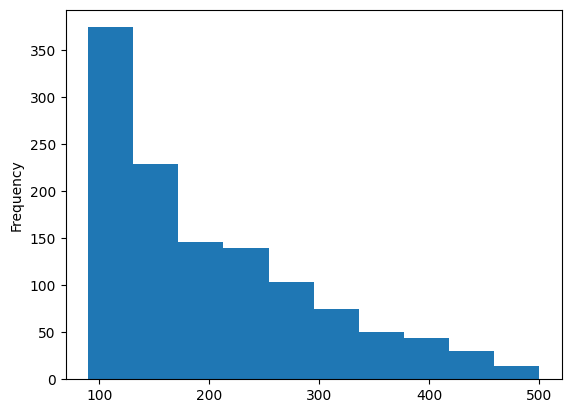

In [76]:
charge.groupby('cid')['charging_power'].count().plot(kind='hist', range=(90,500))

### start ->  finish 정보로 부터 step별 occupancy 여부 생성

In [83]:
charge.set_index('start_time').groupby(pd.Grouper(freq='10min', closed='left'))['cid'].count()

start_time
2021-07-01 00:00:00    10
2021-07-01 00:10:00    16
2021-07-01 00:20:00     8
2021-07-01 00:30:00    10
2021-07-01 00:40:00    10
                       ..
2021-09-30 23:10:00    14
2021-09-30 23:20:00    14
2021-09-30 23:30:00    13
2021-09-30 23:40:00    15
2021-09-30 23:50:00    11
Freq: 10T, Name: cid, Length: 13248, dtype: int64

In [86]:
charge.set_index('start_time').groupby(['cid',pd.Grouper(freq='10min', closed='left')])['cid'].count()

cid    start_time         
7      2021-07-01 05:40:00    1
       2021-07-01 06:20:00    1
       2021-07-01 08:30:00    1
       2021-07-01 11:30:00    1
       2021-07-01 16:10:00    1
                             ..
11056  2021-09-18 14:10:00    1
       2021-09-22 15:50:00    2
       2021-09-24 13:10:00    1
       2021-09-26 16:10:00    1
       2021-09-27 16:40:00    1
Name: cid, Length: 347993, dtype: int64

In [87]:
charge.set_index('start_time').groupby(pd.Grouper(origin='2021-07-01'))['cid'].count()

TypeError: __init__() got an unexpected keyword argument 'origin'

In [78]:
24 * 6 * 2453 * 90

31790880

In [91]:
charge.groupby(pd.Grouper(key='start_time', origin='start_day'))['cid'].count()

TypeError: __init__() got an unexpected keyword argument 'origin'

In [92]:
pd.__version__

'1.5.0'

In [ ]:
pd.Grouper()

In [90]:
help(pd.Grouper)

Help on class Grouper in module pandas.core.groupby.grouper:

class Grouper(builtins.object)
 |  Grouper(*args, **kwargs)
 |  
 |  A Grouper allows the user to specify a groupby instruction for an object.
 |  
 |  This specification will select a column via the key parameter, or if the
 |  level and/or axis parameters are given, a level of the index of the target
 |  object.
 |  
 |  If `axis` and/or `level` are passed as keywords to both `Grouper` and
 |  `groupby`, the values passed to `Grouper` take precedence.
 |  
 |  Parameters
 |  ----------
 |  key : str, defaults to None
 |      Groupby key, which selects the grouping column of the target.
 |  level : name/number, defaults to None
 |      The level for the target index.
 |  freq : str / frequency object, defaults to None
 |      This will groupby the specified frequency if the target selection
 |      (via key or level) is a datetime-like object. For full specification
 |      of available frequencies, please see `here
 |     